# OpenRAO Angle Monitoring in pyPowsybl

In this notebook, we'll explore how OpenRao monitoring algorithms work. 
For network situations with angle or voltage overloads, the monitoring module will try to relieve these constraints by applying remedial actions. 

The first step is to install pypowsybl and import the library.

In [30]:
#pip install pypowsybl==1.12.0

In [31]:
import pypowsybl as pp
from pypowsybl.rao import Parameters as RaoParameters

In [32]:
# set up logging
import logging
logging.getLogger('powsybl').setLevel(logging.INFO)
logging.basicConfig(format='%(asctime)s - %(levelname)s - %(name)s - %(message)s')

Let's load a simple 3 node network.
- VL1 voltage level contains a generator producing 100 MW.
- VL2 voltage level contains a load consuming 100 MW.
- VL1 and VL3 are connected by a PST.
- VL2 and VL3 are connected by 2 lines, one of with has infinite resistance : that's why it has no power flowing through it.

2025-09-08 17:17:53,472 - INFO - powsybl - Loading component library from /DefaultLibrary...
2025-09-08 17:17:53,473 - INFO - powsybl - Loading component library from /DefaultLibrary...
2025-09-08 17:17:53,474 - INFO - powsybl - Number of steps: 139
2025-09-08 17:17:53,475 - INFO - powsybl - Elapsed time: 8.7134E-5


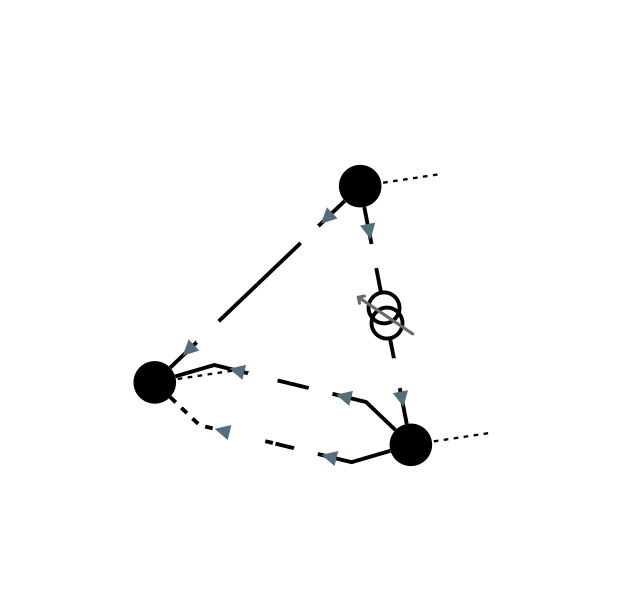

In [33]:
network =  pp.network.load("data/rao/monitoring/network.xiidm")
network.get_network_area_diagram()

Now, let's run a loadflow on this network. We'll then be able to assess which lines are overloaded.

2025-09-08 17:17:53,522 - INFO - powsybl - loadflow provider used is : OpenLoadFlow
2025-09-08 17:17:53,523 - INFO - powsybl - Version: {repositoryName=powsybl-open-loadflow, mavenProjectVersion=1.16.0, gitVersion=9f4cb68a4139a1a5db7353e4b81ae590377f3096, gitBranch=UNKNOWN, buildTimestamp=2025-07-10T12:40:12.650Z}
2025-09-08 17:17:53,527 - INFO - powsybl - Parameters:
┌───────────────────────────┬───────────────────────────────────────────────────────────┬──────────────────────────────────┐
│ Category                  │ Name                                                      │ Value                            │
├───────────────────────────┼───────────────────────────────────────────────────────────┼──────────────────────────────────┤
│ Automation                │ simulateAutomationSystems                                 │ false                            │
│ DC                        │ dcApproximationType                                       │ IGNORE_R                         │
│   

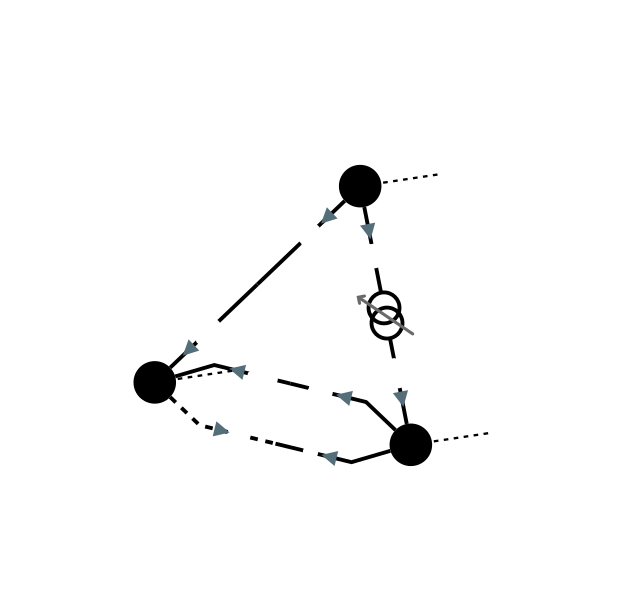

In [34]:
pp.loadflow.run_ac(network)
network.get_network_area_diagram()

The monitoring algorithm is run after a RAO has been run, on a network on which are applied the remedial actions optimized during the RAO to optimize flow CNECs. 
To relieve Angle/Voltage CNECs, we won't be optimizing remedial actions because modelling the impact of remedial actions on angle/voltage values is highly complex and non linear. Instead, we'll be checking application conditions and applying remedial actions until CNECs are relieved.

To run a monitoring, we need to load the following inputs:

In [35]:
parameters = RaoParameters()
parameters.load_from_file_source("./data/rao/monitoring/rao_parameters.json")
load_flow_parameters = parameters.loadflow_and_sensitivity_parameters.sensitivity_parameters.load_flow_parameters

As stated previously, first we'll run a rao and save the rao_result. This rao_result will be used to load activated remedial actions during the monitoring module.

In [36]:
rao_runner = pp.rao.create_rao()
rao_runner.set_crac_file_source(network, "./data/rao/monitoring/angle_monitoring/angle_monitoring_simple_case_with_RA_on_load.json")

In [37]:
rao_result = rao_runner.run(network, parameters)

2025-09-08 17:17:53,692 - WARNING - powsybl - Running RAO using Open RAO version 6.7.0-SNAPSHOT from git commit ea80e63634c4ff2038696d4ca76f99ed861d1263.
2025-09-08 17:17:53,692 - WARNING - powsybl - A threshold for the flowCnec cnec1 - curative is defined in MW but the loadflow computation is in AC. It will be imprecisely converted by the RAO which could create uncoherent results due to side effects
2025-09-08 17:17:53,692 - WARNING - powsybl - A threshold for the flowCnec cnec1 - preventive is defined in MW but the loadflow computation is in AC. It will be imprecisely converted by the RAO which could create uncoherent results due to side effects
2025-09-08 17:17:53,693 - WARNING - powsybl - A threshold for the flowCnec cnec1 - curative is defined in MW but the loadflow computation is in AC. It will be imprecisely converted by the RAO which could create uncoherent results due to side effects
2025-09-08 17:17:53,693 - WARNING - powsybl - A threshold for the flowCnec cnec1 - preventive 

In this case, no remedial actions were applied during the RAO, the network was already secure.

We'll also need a GLSK file to perform redispatching to balance the network following the application of remedial actions. Angle remedial actions are indeed injection actions on generators or loads. 

In [38]:
rao_runner.set_glsk_file_source(network, "./data/rao/monitoring/angle_monitoring/GlskB45test.xml")

2025-09-08 17:17:53,746 - INFO - powsybl - CIM GLSK importer could import this document.


Before running the angle monitoring algorithm, let's look at the angle cnec's situation in the network. As you can see in the crac, AngleCnec acCru1 is defined between exporting element VL2 and importing element VL1, at curative instant after contingency coL1 that disconnects line L1. A minimum threshold is defined at -6°. Let's look at the network after disconnecting L1:

2025-09-08 17:17:53,801 - INFO - powsybl - loadflow provider used is : OpenLoadFlow
2025-09-08 17:17:53,801 - INFO - powsybl - Version: {repositoryName=powsybl-open-loadflow, mavenProjectVersion=1.16.0, gitVersion=9f4cb68a4139a1a5db7353e4b81ae590377f3096, gitBranch=UNKNOWN, buildTimestamp=2025-07-10T12:40:12.650Z}
2025-09-08 17:17:53,805 - INFO - powsybl - Parameters:
┌───────────────────────────┬───────────────────────────────────────────────────────────┬──────────────────────────────────┐
│ Category                  │ Name                                                      │ Value                            │
├───────────────────────────┼───────────────────────────────────────────────────────────┼──────────────────────────────────┤
│ Automation                │ simulateAutomationSystems                                 │ false                            │
│ DC                        │ dcApproximationType                                       │ IGNORE_R                         │
│   

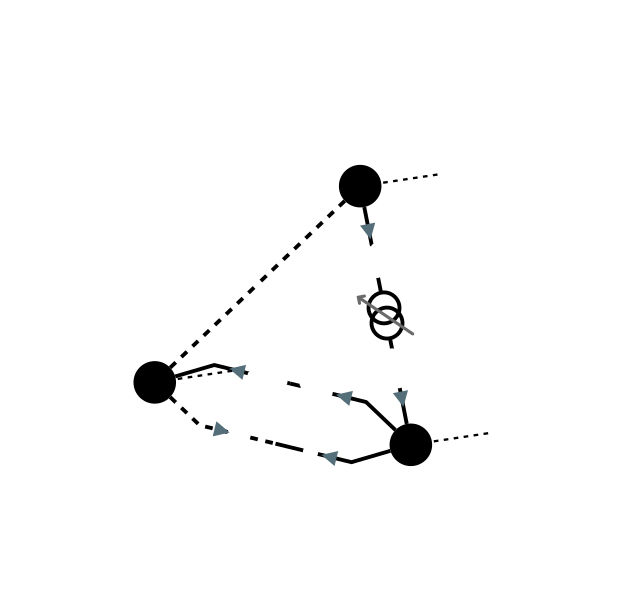

In [39]:
network.disconnect("L1")
pp.loadflow.run_ac(network)
network.get_network_area_diagram()

AngleCnec is unsecure with an angle of -7.7 < -6°.
Now let's run the angle monitoring algorithm.

In [40]:
result_with_angle_monitoring = rao_runner.run_angle_monitoring(network, rao_result, load_flow_parameters, "OpenLoadFlow")
df_angle_cnecs = result_with_angle_monitoring.get_angle_cnec_results()
df_angle_cnecs[['cnec_id', 'angle', 'margin']]

2025-09-08 17:17:53,949 - INFO - powsybl - ----- ANGLE monitoring [start]
2025-09-08 17:17:53,950 - INFO - powsybl - -- 'ANGLE' Monitoring at state 'preventive' [start]
2025-09-08 17:17:53,950 - INFO - powsybl - Load-flow computation [start]
2025-09-08 17:17:53,951 - INFO - powsybl - Version: {repositoryName=powsybl-open-loadflow, mavenProjectVersion=1.16.0, gitVersion=9f4cb68a4139a1a5db7353e4b81ae590377f3096, gitBranch=UNKNOWN, buildTimestamp=2025-07-10T12:40:12.650Z}
2025-09-08 17:17:53,955 - INFO - powsybl - Parameters:
┌───────────────────────────┬───────────────────────────────────────────────────────────┬────────────────────────────────┐
│ Category                  │ Name                                                      │ Value                          │
├───────────────────────────┼───────────────────────────────────────────────────────────┼────────────────────────────────┤
│ Automation                │ simulateAutomationSystems                                 │ false       

,cnec_id,angle,margin
index,,,
2,acCur1,-3.783208,2.216792


During the monitoring algorithm, a network action was applied, setting load LD2's value to 50 MW. The monitoring algorithm tried to perform the opposite redispatching action to maintain network balance, but scaling failed in our case, most likely because the network is so small. Balance was achieved during load flow computation via slack redistribution. 
Applied network action made AngleCnec acCur1 secure, by shifting its' angle from -7.7° to -3.8°.

Only load actions and generator actions can be used to relieve angle cnecs. In the following example, a topological action is defined (open L3) but it isn't even considered to relieve AngleCnec acCur1.

In [41]:
network_2 = pp.network.load("./data/rao/monitoring/network.xiidm")
rao_runner_2 = pp.rao.create_rao()
rao_runner_2.set_crac_file_source(network_2, "./data/rao/monitoring/angle_monitoring/angle_monitoring_simple_case_with_topo.json")
rao_result_2 = rao_runner_2.run(network_2, parameters)
print(rao_result_2.to_json())
rao_runner_2.set_glsk_file_source(network_2, "./data/rao/monitoring/angle_monitoring/GlskB45test.xml")
result_with_angle_monitoring_2 = rao_runner_2.run_angle_monitoring(network_2, rao_result_2, load_flow_parameters, "OpenLoadFlow")
df_angle_cnecs_2 = result_with_angle_monitoring_2.get_angle_cnec_results()
df_angle_cnecs_2[['cnec_id', 'angle', 'margin']]

2025-09-08 17:17:54,262 - WARNING - powsybl - Running RAO using Open RAO version 6.7.0-SNAPSHOT from git commit ea80e63634c4ff2038696d4ca76f99ed861d1263.
2025-09-08 17:17:54,263 - WARNING - powsybl - A threshold for the flowCnec cnec1 - curative is defined in MW but the loadflow computation is in AC. It will be imprecisely converted by the RAO which could create uncoherent results due to side effects
2025-09-08 17:17:54,263 - WARNING - powsybl - A threshold for the flowCnec cnec1 - preventive is defined in MW but the loadflow computation is in AC. It will be imprecisely converted by the RAO which could create uncoherent results due to side effects
2025-09-08 17:17:54,263 - WARNING - powsybl - A threshold for the flowCnec cnec1 - curative is defined in MW but the loadflow computation is in AC. It will be imprecisely converted by the RAO which could create uncoherent results due to side effects
2025-09-08 17:17:54,264 - WARNING - powsybl - A threshold for the flowCnec cnec1 - preventive 

{'type': 'RAO_RESULT', 'version': '1.8', 'info': 'Generated by Open RAO https://powsybl.readthedocs.io/projects/openrao', 'computationStatus': 'default', 'executionDetails': 'The RAO only went through first preventive', 'costResults': {'initial': {'functionalCost': -5.0, 'virtualCost': {'sensitivity-failure-cost': 0.0}}, 'preventive': {'functionalCost': -5.0, 'virtualCost': {'sensitivity-failure-cost': 0.0}}, 'outage': {'functionalCost': -5.0, 'virtualCost': {'sensitivity-failure-cost': 0.0}}, 'auto': {'functionalCost': -5.0, 'virtualCost': {'sensitivity-failure-cost': 0.0}}, 'curative': {'functionalCost': -5.0, 'virtualCost': {'sensitivity-failure-cost': 0.0}}}, 'computationStatusMap': [], 'flowCnecResults': [{'flowCnecId': 'cnec1 - curative', 'initial': {'megawatt': {'margin': 5.0, 'side2': {'flow': 0.0}}}, 'preventive': {'megawatt': {'margin': 5.0, 'side2': {'flow': 0.0}}}, 'auto': {'megawatt': {'margin': 5.0, 'side2': {'flow': 0.0}}}, 'curative': {'megawatt': {'margin': 5.0, 'side2

,cnec_id,angle,margin
index,,,
3,acCur1,-7.713852,-4.713852
